Script for detecting the receptive field of task responding neurons
- First, we detect the neurons involved in the task computing the t-test between activity during different epochs vs fixation
- Second, from those neurons we compare the fr response against oposit positions (t-test to check significance)
- Third, compute indices for evaluating if visual, memory or motor neuron  

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.analysis import raw_ch
from ephysvibe.task import task_constants,def_task
import os 

## Def funtions

In [2]:
def get_neurons_info(neuron_type:np.ndarray,target_codes:Dict,ipsi:np.ndarray,contra:np.ndarray,neuron_idx:np.ndarray=None)->pd.DataFrame:
    if neuron_idx is None:
        neuron_idx = np.arange(0,len(neuron_type))
    codes =  target_codes.keys()
    neurons_info:Dict[str,list] = defaultdict(list)
    i_good,i_mua, n_type = 0,0,0
    for i_neuron,type_neuron in zip(neuron_idx,neuron_type):
        # check and count type of unit
        if type_neuron == 'good':
            i_good+=1
            n_type = i_good
        elif type_neuron == 'mua':
            i_mua+=1
            n_type = i_mua
        for code in codes: # iterate by code'
            if code in ipsi:
                laterality = 'ipsi'
            else:
                laterality='contra'
            neurons_info['code']+=[code]
            neurons_info['laterality']+=[laterality]
            neurons_info['cluster']+=[n_type]
            neurons_info['group']+=[type_neuron]
            neurons_info['array_position']+=[i_neuron]
    neurons_info = pd.DataFrame(neurons_info)
    return neurons_info

In [3]:
def get_responding_neurons(neurons_info:pd.DataFrame,epochs:Dict,before_trial:int,code_samples:np.ndarray,code_numbers:np.ndarray,sp_samples:np.ndarray,
                           align_event:int,target_codes:Dict,n_spikes_sec:np.ndarray= 5)->pd.DataFrame:
    end_time = np.array(epochs['end_time']) + before_trial
    start_time = np.array(epochs['start_time']) + before_trial
    test_involved:Dict[str,list] = defaultdict(list)

    for _, row in neurons_info.iterrows():
        i_neuron = row['array_position']
        code = row['code']
        for i_st, i_end,i_epoch in zip(start_time,end_time,epochs['name']): # iterate by event
            target_t_idx = target_codes[code]["trial_idx"] # select trials with the same stimulus location
            trials_event_time = code_samples[ target_t_idx, np.where(code_numbers[target_t_idx] == align_event)[1]] # moment when the target_on ocurrs in each trial
            shift_sp = TrialsData.indep_roll(sp_samples[target_t_idx,i_neuron], -(trials_event_time-before_trial).astype(int), axis=1) # align trials with (target_on - before_trial)
            # select trials with at least one spike
            shift_sp = shift_sp[np.nansum(shift_sp,axis=1)>0]
            # check number of spikes, at least 5/sec 
            if np.any(np.sum(shift_sp[:, before_trial:epochs["end_time"][-1]+before_trial],axis=1)>=n_spikes_sec * (epochs["end_time"][-1]/1000)): # if at least n_spikes_sec, compute and save t-test in pd.DataFrame
                # mean fr during event
                mean_sp = shift_sp[:, i_st:i_end].mean(axis=0) # Average fr of all trials 
                # mean fr during fixation
                mean_sp_fix = shift_sp[:, :before_trial].mean(axis=0)# Average fr of all trials 
                p=stats.ttest_ind(mean_sp, mean_sp_fix)[1]
                message = ''
            else:
                p = np.nan
                message = "less than %s spikes/sec"%n_spikes_sec
            test_involved['code']+=[code]
            test_involved['laterality']+=[row['laterality']]
            test_involved['cluster']+=[row['cluster']]
            test_involved['group']+=[row['group']]
            test_involved['array_position']+=[i_neuron]
            test_involved['event']+=[i_epoch]
            test_involved['p']+=[p]
            test_involved['message']+=[message]
    test_involved = pd.DataFrame(test_involved)
        
    return test_involved

In [4]:
# def get_responding_neurons(epochs:Dict,before_trial:int,neuron_type:np.ndarray,code_samples:np.ndarray,code_numbers:np.ndarray,sp_samples:np.ndarray,
#                            align_event:int,target_codes:Dict,neuron_idx:np.ndarray=None,n_spikes_sec:np.ndarray= 5)->pd.DataFrame:
#     """_summary_

#     Args:
#         epochs (Dict): _description_
#         before_trial (int): _description_
#         neuron_type (np.ndarray): _description_
#         code_samples (np.ndarray): _description_
#         code_numbers (np.ndarray): _description_
#         sp_samples (np.ndarray): _description_
#         align_event (int): _description_
#         target_codes (Dict): _description_
#         neuron_idx (np.ndarray, optional): _description_. Defaults to None.
#         n_spikes_sec (np.ndarray, optional): _description_. Defaults to 5.

#     Returns:
#         pd.DataFrame: _description_
#     """
#     if neuron_idx is None:
#         neuron_idx = np.arange(0,len(neuron_type))
#     codes =  target_codes.keys()
#     end_time = np.array(epochs['end_time']) + before_trial
#     start_time = np.array(epochs['start_time']) + before_trial
#     test_involved:Dict[str,list] = defaultdict(list)
#     i_good,i_mua, n_type = 0,0,0
#     for i_neuron,type_neuron in zip(neuron_idx,neuron_type):
#         # check and count type of unit
#         if type_neuron == 'good':
#             i_good+=1
#             n_type = i_good
#         elif type_neuron == 'mua':
#             i_mua+=1
#             n_type = i_mua
#         for i_st, i_end,i_epoch in zip(start_time,end_time,epochs['name']): # iterate by event
#             for code in codes: # iterate by code'
#                 target_t_idx = target_codes[code]["trial_idx"] # select trials with the same stimulus location
#                 trials_event_time = code_samples[ target_t_idx, np.where(code_numbers[target_t_idx] == align_event)[1]] # moment when the target_on ocurrs in each trial
#                 shift_sp = TrialsData.indep_roll(sp_samples[target_t_idx,i_neuron], -(trials_event_time-before_trial).astype(int), axis=1) # align trials with (target_on - before_trial)
#                 # select trials with at least one spike
#                 shift_sp = shift_sp[np.nansum(shift_sp,axis=1)>0]
#                 # check number of spikes, at least 5/sec 
#                 if np.any(np.sum(shift_sp[:, before_trial:epochs["end_time"][-1]+before_trial],axis=1)>=n_spikes_sec * (epochs["end_time"][-1]/1000)): # if at least n_spikes_sec, compute and save t-test in pd.DataFrame
#                     # mean fr during event
#                     mean_sp = shift_sp[:, i_st:i_end].mean(axis=0) # Average fr of all trials 
#                     # mean fr during fixation
#                     mean_sp_fix = shift_sp[:, :before_trial].mean(axis=0)# Average fr of all trials 
#                     p=stats.ttest_ind(mean_sp, mean_sp_fix)[1]
#                     message = ''
#                 else:
#                     p = None
#                     message = "less than %s spikes/sec"%n_spikes_sec
#                 test_involved['code']+=[code]
#                 test_involved['cluster']+=[n_type]
#                 test_involved['group']+=[type_neuron]
#                 test_involved['array_position']+=[i_neuron]
#                 test_involved['event']+=[i_epoch]
#                 test_involved['p']+=[p]
#                 test_involved['message']+=[message]
#     test_involved = pd.DataFrame(test_involved)
#     return test_involved

In [30]:
def get_rf(th_involved:pd.DataFrame,sp_samples:np.ndarray,ipsi:np.ndarray,contra:np.ndarray,target_codes:Dict,code_samples:np.ndarray,align_event:int,code_numbers:np.ndarray,dur_v:int,st_m:int,end_m:int)->pd.DataFrame:
    test_rf:Dict[str,list] = defaultdict(list)
    for _, row in th_involved.iterrows():
        i_neuron = row['array_position']
        code = row['code']
        event = row['event']   
        if code in ipsi:
            idx = np.where(ipsi == code)[0]
            opposite_code = contra[idx][0]
        else:
            idx = np.where(contra == code)[0]
            opposite_code = ipsi[idx][0]
        # code
        target_t_idx = target_codes[code]["trial_idx"] # select trials with the same stimulus
        trials_event_time = code_samples[target_t_idx, np.where(code_numbers[target_t_idx] == align_event)[1]] # moment when the target_on ocurrs in each trial        
        shift_sp_r = TrialsData.indep_roll(sp_samples[target_t_idx,i_neuron], -(trials_event_time).astype(int), axis=1) # align trials with event onset
        shift_sp_r = shift_sp_r[np.nansum(shift_sp_r,axis=1)>0]# Select trials with at least one spike
        # opposite_code
        target_t_idx = target_codes[opposite_code]["trial_idx"] # select trials with the same stimulus
        trials_event_time = code_samples[target_t_idx, np.where(code_numbers[target_t_idx] == align_event)[1]] # moment when the target_on ocurrs in each trial
        shift_sp_l = TrialsData.indep_roll(sp_samples[target_t_idx,i_neuron], -(trials_event_time).astype(int), axis=1)# align trials with event onset
        shift_sp_l = shift_sp_l[np.nansum(shift_sp_l,axis=1)>0]# Select trials with at least one spike
        # Average fr of all trials  
        if event == 'visual': # visuel 
            mean_sp_code = shift_sp_r[:, :dur_v].mean(axis=0) 
            mean_sp_opposite = shift_sp_l[:, :dur_v].mean(axis=0)   
        elif event == 'anticipation': # motor 
            mean_sp_code = shift_sp_r[:, st_m:end_m].mean(axis=0)   
            mean_sp_opposite = shift_sp_l[:, st_m:end_m].mean(axis=0)                
        else:# i_vm_idx <= -vm_threshold: # visuomotor 
            mean_sp_code = shift_sp_r[:, :1100].mean(axis=0)   
            mean_sp_opposite = shift_sp_l[:, :1100].mean(axis=0)   
        p = stats.ttest_ind(mean_sp_code, mean_sp_opposite)[1]
        larger = mean_sp_code.mean()>mean_sp_opposite.mean()
        test_rf['code']+=[code]
        test_rf['array_position']+=[i_neuron]
        test_rf['p']+=[p ]  
        test_rf['larger']+=[larger]  
        test_rf['type']+=[event]  
        test_rf['cluster']+=[row['cluster']]
        test_rf['group']+=[row['group']]
    test_rf = pd.DataFrame(test_rf)
    return test_rf

In [33]:
def get_vm_index(th_rf,target_codes,code_samples,code_numbers,sp_samples,align_event,fix_t,dur_v,st_m,end_m,fs_ds,kernel):
    test_vm:Dict[str,list] = defaultdict(list)
    for _, row in th_rf.iterrows():
        i_neuron = row['array_position']
        code = row['code']
        # event = row['event']   
        target_t_idx = target_codes[code]["trial_idx"] # select trials with the same stimulus
        # select trials
        trials_event_time = code_samples[target_t_idx, np.where(code_numbers[target_t_idx] == align_event)[1]] # moment when the target_on ocurrs in each trial
        shift_sp = TrialsData.indep_roll(sp_samples[target_t_idx,i_neuron], -(trials_event_time-fix_t).astype(int), axis=1) # align trials with event onset
        shift_sp = shift_sp[np.nansum(shift_sp,axis=1)>0]# select trials with at least one spike
        # visual response
        # shift_sp_visual = shift_sp[:, fix_t:fix_t+dur_v]
        # motor response 
        # shift_sp_motor = shift_sp[:, fix_t+st_m:fix_t+end_m]
        # fix response
        # mean_sp_fix = shift_sp[:, :fix_t].mean()
        # compute index
        # m_mean = np.abs(shift_sp_motor.mean() - mean_sp_fix)
        # v_mean = np.abs(shift_sp_visual.mean() - mean_sp_fix)
        conv = (np.convolve(shift_sp[:, :fix_t+end_m+100].mean(axis=0), kernel, mode="same") * fs_ds)
        m_mean = (conv[fix_t+st_m:fix_t+end_m].mean()-conv[fix_t:fix_t+end_m].min())
        v_mean = (conv[fix_t:fix_t+dur_v].mean()-conv[fix_t:fix_t+end_m].min()) 
        vm_index = (m_mean-v_mean)/(v_mean+m_mean)
        # save results
        test_vm['code']+=[code]
        test_vm['array_position']+=[i_neuron]
        test_vm['vm_index']+=[vm_index]
        test_vm['sig_type']+=[row['type']]  
        test_vm['cluster']+=[row['cluster']]
        test_vm['group']+=[row['group']]
    test_vm = pd.DataFrame(test_vm)
    return test_vm

In [35]:
def get_max_fr(target_codes,sp_samples,code_samples,code_numbers,i_n,kernel,win_size,e_code_align,test_vm,fs_ds):
    fr_max_visual,fr_max_motor,fr_angle,fr_max_trial,v_significant,m_significant = [],[],[],[],[],[]   
    for code in target_codes.keys():
        target_t_idx = target_codes[code][
            "trial_idx"
        ]  # select trials with the same stimulus
        trials_s_on = code_samples[target_t_idx,np.where(code_numbers[target_t_idx] == e_code_align)[1]]  
        shift_sp = TrialsData.indep_roll(sp_samples[target_t_idx, i_n],-(trials_s_on-win_size).astype(int),axis=1)  # align trials on event
        # select trials with at least one spike
        shift_sp = shift_sp[np.nansum(shift_sp, axis=1) > 0]
        mean_sp = shift_sp.mean(axis=0)  # mean of all trials
        conv = np.convolve(mean_sp, kernel, mode="same") * fs_ds
        fr_max_visual.append(max(conv[win_size:win_size+dur_v]))
        fr_angle.append(target_codes[code]['angle_codes'])
        fr_max_motor.append(max(conv[ win_size+800:win_size+1100]))
        fr_max_trial.append(max(conv[win_size:win_size+1100]))
        if code in test_vm[(test_vm["array_position"] == i_n)&(test_vm["sig_type"]=='visual')]["code"].values:
            v_significant.append(True)
        else:
            v_significant.append(False)
        if code in test_vm[(test_vm["array_position"] == i_n)&(test_vm["sig_type"]=='anticipation')]["code"].values:
            m_significant.append(True)
        else:
            m_significant.append(False)
    return fr_max_visual,fr_max_motor,fr_angle,fr_max_trial,v_significant,m_significant

## Load data

In [8]:
# load data
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-02-09_10-42-54_Riesling_lip_e1_r1.h5" #2023-02-27_10-50-03 2023-02-09_10-42-54
s_path = os.path.normpath(filepath).split(os.sep)
data = TrialsData.from_python_hdf5(filepath)

In [9]:
# Select trials and create task frame
block = 2
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == block))[0]
print("Number of clusters: %d" % len(data.clustersgroup))

Number of clusters: 4


In [10]:
# Define target codes 
position_codes= {
    # code: [[MonkeyLogic axis], [plot axis]]
    '127': [[10,0],[1,2],[0]],
    '126': [[7,7],[0,2],[45]],
    '125': [[0,10],[0,1],[90]],
    '124': [[-7,7],[0,0],[135]],
    '123': [[-10,0],[1,0],[180]],
    '122': [[-7,-7],[2,0],[225]],
    '121': [[0,-10],[2,1],[270]],
    '120': [[7,-7],[2,2],[315]],
}
# create dict with the trials having each code
target_codes = {}
for i_key,key in enumerate(position_codes.keys()):
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, data.code_numbers[trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    target_codes[key]={'code_idx':code_idx,'trial_idx':trials,'position_codes':position_codes[key][1],'angle_codes':position_codes[key][2][0]}

In [11]:
neuron_type = data.clustersgroup
ipsi = np.array(['124','123','122','121'])
contra = np.array(['120','127','126','125'])
neurons_info = get_neurons_info(neuron_type,target_codes,ipsi,contra,neuron_idx=None)

### Neurons responding to the task
check whether the neuron is responding to the task comparing each epoch with fixation 

In [12]:
data.clustersgroup

array(['good', 'good', 'good', 'mua'], dtype='<U4')

In [13]:
fix_t = 200
dur_v = 250
st_m = 800
end_m = 1100
epochs = {"name":['visual','delay','anticipation'],
          "start_time":[0,350,st_m],
          "end_time":[dur_v,750,end_m]}
before_trial = fix_t
neuron_type = data.clustersgroup
code_samples = data.code_samples
code_numbers = data.code_numbers
sp_samples = data.sp_samples
align_event = task_constants.EVENTS_B2['target_on']
test_involved = get_responding_neurons(neurons_info,epochs,before_trial,code_samples,code_numbers,sp_samples,align_event,target_codes,n_spikes_sec= 5)

In [14]:
p_threshold = 0.05
th_involved = test_involved[test_involved['p']<p_threshold] # results below threshold
significant_units = th_involved['array_position'].unique()
print('Units showing significant activity: %s'%significant_units)
th_involved

Units showing significant activity: [0 1 2]


,code,laterality,cluster,group,array_position,event,p,message
3,126,contra,1,good,0,visual,2.942291e-03,
4,126,contra,1,good,0,delay,3.069932e-04,
9,124,ipsi,1,good,0,visual,6.652819e-05,
12,123,ipsi,1,good,0,visual,1.393434e-06,
23,120,contra,1,good,0,anticipation,4.900393e-02,
24,127,contra,2,good,1,visual,1.212633e-02,
29,126,contra,2,good,1,anticipation,2.128906e-02,
31,125,contra,2,good,1,delay,1.112567e-02,
32,125,contra,2,good,1,anticipation,7.178542e-03,
33,124,ipsi,2,good,1,visual,4.677518e-06,


### Neurons RF
Check if signif compared to opposite location

In [31]:
sp_samples=data.sp_samples
code_samples = data.code_samples
align_event = task_constants.EVENTS_B2['target_on']
rf_test = get_rf(th_involved,sp_samples,ipsi,contra,target_codes,code_samples,align_event,code_numbers,dur_v,st_m,end_m)  

In [32]:
p_threshold = 0.05
th_rf = rf_test[np.logical_and(rf_test['p']<p_threshold,rf_test['larger']==True)] # results below threshold
significant_units = th_rf['array_position'].unique()
print('Units showing significant activity: %s'%significant_units)
th_rf

Units showing significant activity: [0 1 2]


,code,array_position,p,larger,type,cluster,group
2,124,0,3.539321e-06,True,visual,1,good
3,123,0,4.659567e-12,True,visual,1,good
5,127,1,1.590342e-04,True,visual,2,good
17,121,1,5.254381e-04,True,delay,2,good
18,120,1,9.745608e-05,True,visual,2,good
19,127,2,1.440087e-20,True,visual,3,good
20,126,2,2.677382e-16,True,visual,3,good
21,126,2,5.595307e-13,True,delay,3,good
22,125,2,6.746754e-03,True,visual,3,good
26,120,2,2.917144e-09,True,visual,3,good


### Visuomotor index
check whether a neuron is visual, motor or visuomotor comparing the activity during sample presentation vs motor preparation

In [34]:
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
code_samples=data.code_samples
sp_samples = data.sp_samples
code_numbers = data.code_numbers
align_event = task_constants.EVENTS_B2['target_on']
test_vm=get_vm_index(th_rf,target_codes,code_samples,code_numbers,sp_samples,align_event,fix_t,dur_v,st_m,end_m,fs_ds,kernel)
no_dup_vm = test_vm[test_vm.columns[:-3]].drop_duplicates()

In [18]:
no_dup_vm

,code,array_position,vm_index
0,124,0,-0.669891
1,123,0,-0.741732
2,127,1,-0.505384
3,121,1,0.228600
4,120,1,-0.502097
5,127,2,-0.925549
6,126,2,-0.892422
8,125,2,-0.956656
9,120,2,-0.920869


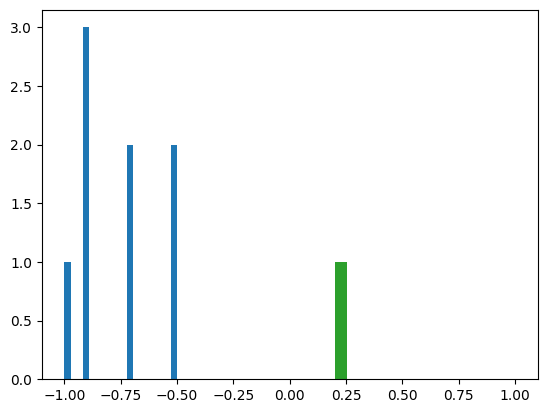

In [19]:
idx_plot = np.around(no_dup_vm['vm_index'].values,1)
vm_threshold = 0.4
plt.hist(idx_plot[idx_plot<=-vm_threshold],bins=18)
plt.hist(idx_plot[idx_plot>=vm_threshold],bins=18)
a=plt.hist(idx_plot[np.logical_and(idx_plot>-vm_threshold,idx_plot<vm_threshold)],bins=18)

### Plot fr and circular max fr/localion

In [20]:
color={'visual':['salmon','darkred','--'],'motor':['royalblue','navy','-.']}

/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


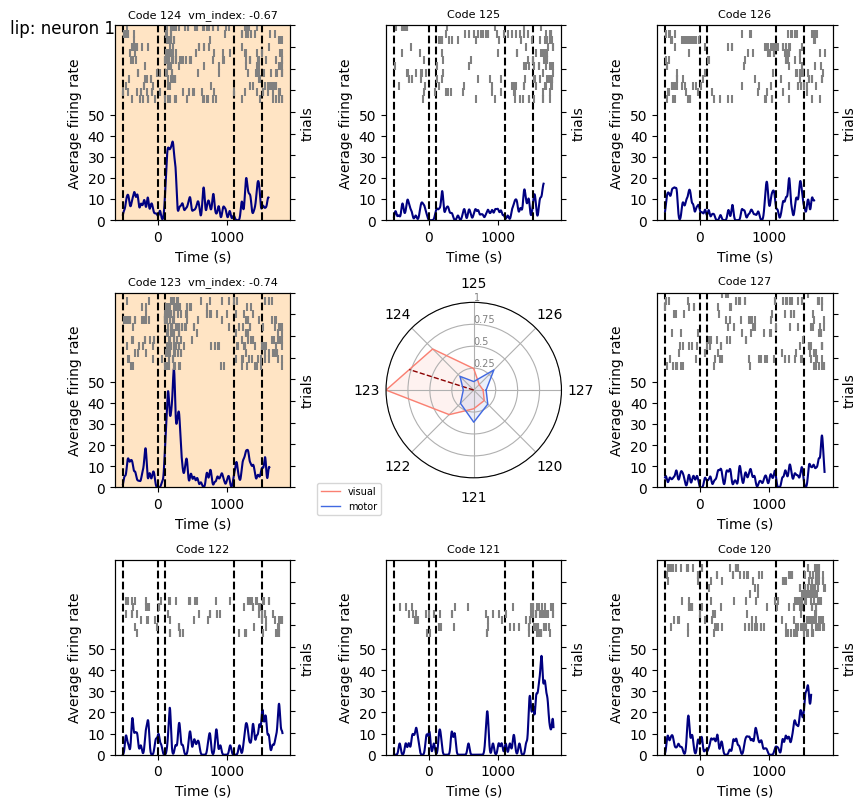

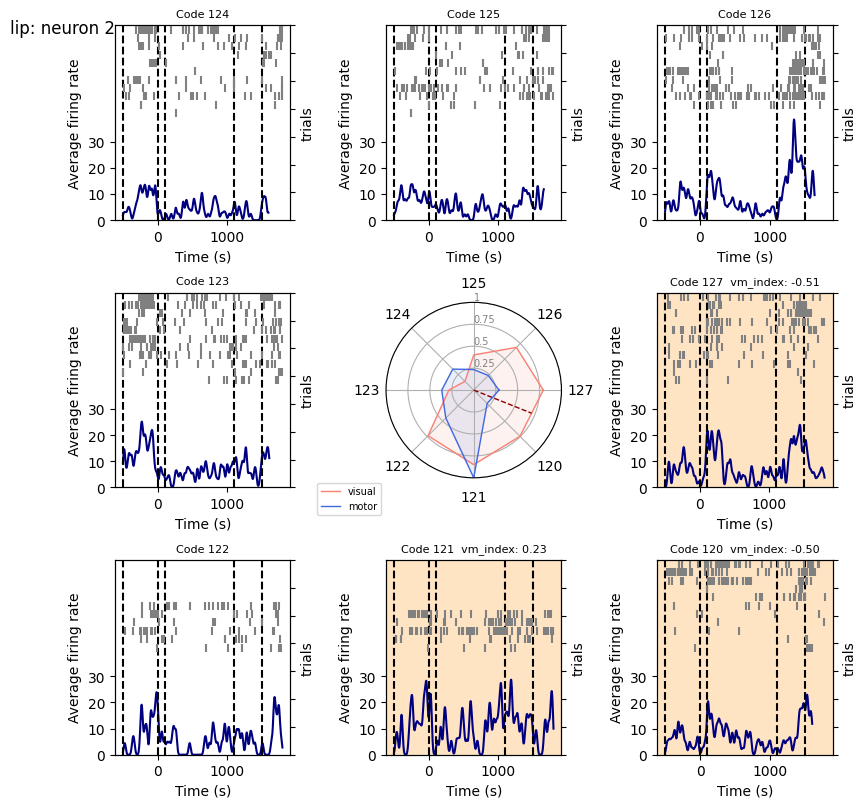

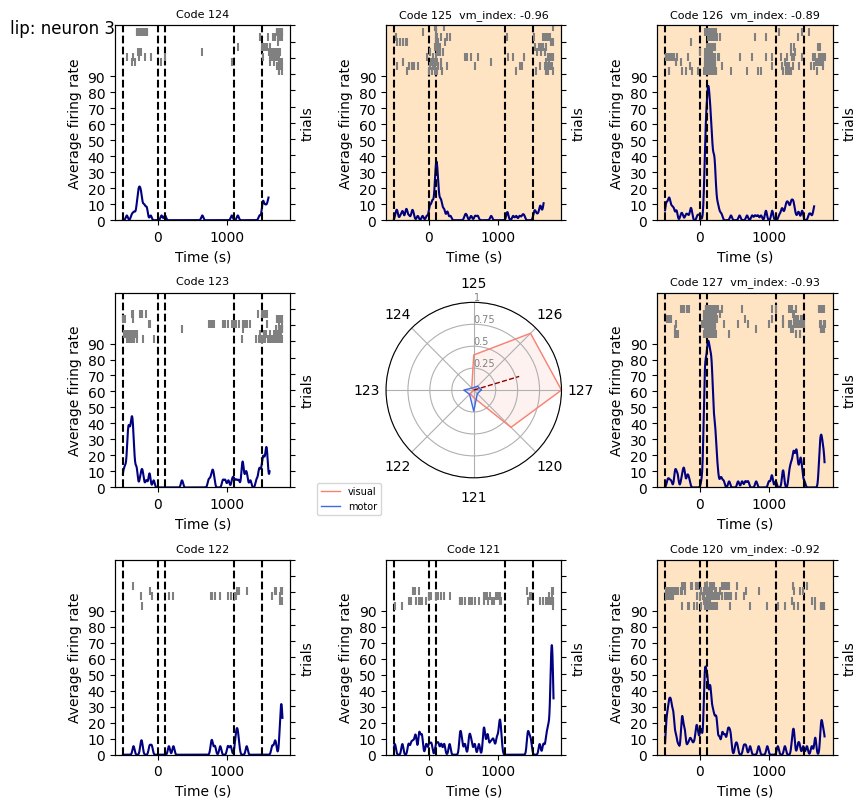

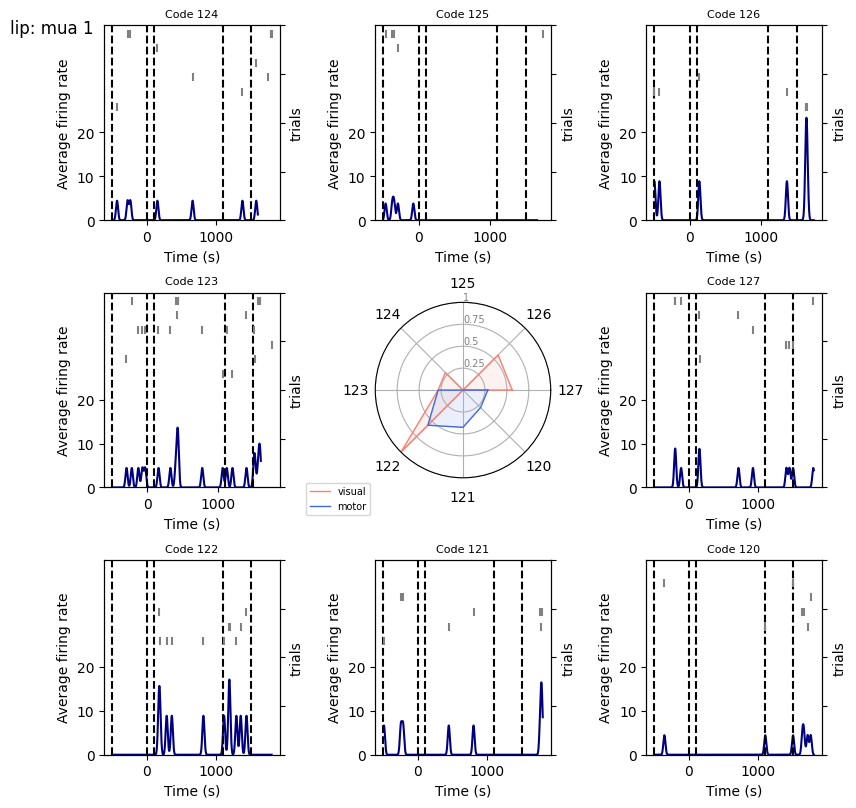

In [36]:
# kernel parameters
t_before=500
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
win_size = int(sp_constants.W_SIZE * fs_ds)
code_samples=data.code_samples
code_numbers=data.code_numbers
sp_samples=data.sp_samples
e_code_align = task_constants.EVENTS_B2['target_on']
# select only individual neurons
rf_coordinates:Dict[str,list] = defaultdict(list)
i_neuron, i_mua = 1, 1
for i_n, cluster in enumerate(data.clustersgroup): # iterate by units
    if cluster == "good":
        i_cluster = i_neuron
        i_neuron += 1
        cluster = "neuron"
    else:
        i_cluster = i_mua
        i_mua += 1
    fig, _ = plt.subplots(figsize=(8, 8), sharex=True, sharey=True) # define figure
    all_ax, all_ax2,all_max_conv,max_num_trials=plot_raster.plot_activity_location(target_codes,code_samples,code_numbers,sp_samples, i_n, e_code_align, t_before,fs_ds, kernel,no_dup_vm)
    # ------------------ plot spider in the center 
    fr_max_visual,fr_max_motor,fr_angle,fr_max_trial,v_significant,m_significant = get_max_fr(target_codes,sp_samples,code_samples,code_numbers,i_n,kernel,win_size,e_code_align,test_vm,fs_ds)
    fr_max_trial = max(fr_max_trial)
    ax = plt.subplot2grid((3, 3), (1, 1), polar=True)
    fr_angle_rad=((np.array(fr_angle)*2 * np.pi )/360).tolist()
    fr_angle_rad += fr_angle_rad[:1]
    for fr_max,event,significant in zip([fr_max_visual, fr_max_motor],['visual','motor'],[v_significant,m_significant]):
        norm_fr_max = (np.array(fr_max)/fr_max_trial).tolist()
        norm_fr_max += norm_fr_max[:1]
        ax.set_rlabel_position(90)
        plt.yticks([0.25,0.5,0.75,1], ['0.25','0.5','0.75','1'], color="grey", size=7)
        plt.ylim(0,1)
        plt.xticks(fr_angle_rad[:-1], target_codes.keys())
        ax.plot(fr_angle_rad, norm_fr_max, linewidth=1, linestyle='solid',color=color[event][0], label=event)
        ax.fill(fr_angle_rad, norm_fr_max, alpha=0.1,color=color[event][0])
        # plot resultant              
        r_vector = np.mean((np.array(norm_fr_max[:-1])*np.cos(fr_angle_rad[:-1]))[significant])
        im_vector = np.mean((np.array(norm_fr_max[:-1])*np.sin(fr_angle_rad[:-1]))[significant])
        ang = np.angle([r_vector+ 1j *(im_vector)])[0]
        if ang < 0:
            ang=ang+2*np.pi
        rad = np.abs([r_vector+ 1j *(im_vector)])[0]
        ax.plot([0,ang], [0,rad], linewidth=1, linestyle=color[event][2], color=color[event][1])
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 7})
        rf_coordinates['i_neuron'] += [i_n] 
        rf_coordinates['event'] += [event]
        rf_coordinates['rad'] += [rad]
        rf_coordinates['ang'] += [ang]
        rf_coordinates['date'] += [ang]
    ## ------------------ end spider
    avg_events = [-500, 0, 100,1100,1500]
    num_trials = sp_samples.shape[0]
    for ax, ax2 in zip(all_ax, all_ax2):
        for ev in avg_events:
            ax.vlines(
                ev,
                0,
                all_max_conv + max_num_trials * 3,
                color="k",
                linestyles="dashed",
            )  # target_on
        ax.set_ylim(0, all_max_conv + max_num_trials * 3)
        ax.set_yticks(np.arange(0, all_max_conv, 10))
        ax2.set_ylim(-all_max_conv, max_num_trials)
        ax2.set_yticks(np.arange(-all_max_conv, max_num_trials * 3, 10))
        ax.set(xlabel="Time (s)", ylabel="Average firing rate")
        ax2.set(xlabel="Time (s)", ylabel="trials")
        plt.setp(ax2.get_yticklabels(), visible=False)
    fig.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    fig.suptitle("%s: %s %d" % (s_path[-2], cluster, i_cluster), x=0)
rf_coordinates = pd.DataFrame(rf_coordinates)

In [23]:
rf_coordinates

,i_neuron,event,rad,ang
0,0,visual,0.770613,2.832833
1,0,motor,NaN,NaN
2,1,visual,0.710347,5.903134
3,1,motor,NaN,NaN
4,2,visual,0.540879,0.292026
5,2,motor,NaN,NaN
6,3,visual,NaN,NaN
7,3,motor,NaN,NaN
